# Preambles

In [1]:
%load_ext autoreload
%autoreload 2

import os 
import dotenv 
import sys

# Load the environment variables
dotenv.load_dotenv()

# Add the environment variable PROJECT_ROOT to the Python path
project_root = os.getenv('PROJECT_ROOT')
if project_root:
    sys.path.append(project_root)
    print(f"Added {project_root} to the Python path")
else:
    print("PROJECT_ROOT environment variable not found")

import importlib 
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import networkx as nx

Added /Volumes/CrucialX/project-akrav to the Python path


# I/O and Verifications
## Load Data

In [3]:
# Load the routes from one file
route_df = pd.read_csv(os.path.join(project_root, 'data', 'routes_wps', 'cs_2023-04-01.routes.csv'))
# Only keep the columns without the word 'full' in it 
route_df = route_df.loc[:, ~route_df.columns.str.contains('full')]
route_df.head(5)

,flight_id,real_waypoints,pass_times,speeds,alts
0,000042HMJ225,INKIM LJLJ LMML MALTI,1680349300 1680364679 1680382679 1680382679,0.2321 0.1399 0.0000 0.0000,11521 1570 114 114
1,010092MSR741,LAKTO BIRES_29 LCLK,1680362648 1680362759 1680364319,0.2708 0.2365 0.0000,9312 9312 434
2,010092MSR742,LCA SOBOS_91 SISIM,1680368182 1680368399 1680369839,0.1243 0.1648 0.0000,1265 3947 10257
3,010092MSR831,TANSA_98 METRU METRU_30 TOTTI LOTIN REXUN,1680335357 1680335219 1680335279 1680339179 16...,0.2004 0.2004 0.2197 0.2102 0.2241 0.0000,11133 11133 11133 11217 10150 5197
4,010092MSR832,ODGAX LUMED METRU_30,1680346619 1680347039 1680350699,0.2367 0.2639 0.0000,6568 8771 10851


In [4]:
# Load the NAV data
G = nx.read_gml(os.path.join(project_root, 'data', 'graphs', 'ats_fra_nodes_only.gml'))
print(f'The graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges')
# Convert G into a directed graph
G = nx.DiGraph(G)
print(f'The directed graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges')


The graph has 33763 nodes and 0 edges
The directed graph has 33763 nodes and 0 edges


## Check the segments: distance and speed

In [5]:
from utils.haversine import haversine_distance 

def print_segment_stats(route_waypoints: str, pass_times_str: str, G) -> None:
    """
    Given:
      - route_waypoints: e.g. "INKIM LJLJ LMML MALTI"
      - pass_times_str:  e.g. "1680349300 1680364679 1680382679 1680382679"
      - G: a networkx.Graph whose nodes have 'lat' and 'lon' attributes
    
    Prints for each consecutive pair:
      "{FROM}-{TO}: XX.X km, YY minutes, ZZ km/h"
    """
    waypoints = route_waypoints.split()
    pass_times = [int(ts) for ts in pass_times_str.split()]

    if len(waypoints) != len(pass_times):
        raise ValueError("Number of waypoints and pass times must match")

    # loop over each segment
    for start, end, t0, t1 in zip(waypoints, waypoints[1:], pass_times, pass_times[1:]):
        # fetch coordinates
        lat1, lon1 = G.nodes[start]['lat'], G.nodes[start]['lon']
        lat2, lon2 = G.nodes[end]['lat'],   G.nodes[end]['lon']

        # distance in nautical miles → convert to km
        dist_nm = haversine_distance(lat1, lon1, lat2, lon2)
        dist_km = dist_nm * 1.852

        # time difference
        dt_sec = t1 - t0
        dt_min = dt_sec / 60.0

        # avg. speed in km/h
        if dt_sec > 0:
            speed_kmh = dist_km / (dt_sec / 3600.0)
        else:
            speed_kmh = float('inf')

        print(f"{start}-{end}: {dist_km:.1f} km, "
              f"{int(round(dt_min))} minutes, "
              f"{speed_kmh:.1f} km/h")


In [6]:
for i in range(10, 30):
    route = route_df.iloc[i]
    print_segment_stats(route['real_waypoints'], route['pass_times'], G)
    print('-'*10)

USEBE-KOMEZ: 32.3 km, 1 minutes, 1971.6 km/h
KOMEZ-EDASA: 584.2 km, 46 minutes, 762.0 km/h
EDASA-LTFJ: 174.3 km, 16 minutes, 653.6 km/h
LTFJ-LTFM: 62.8 km, 16 minutes, 235.3 km/h
----------
FATIH-RATVU: 154.9 km, 14 minutes, 647.5 km/h
RATVU-AYT: 354.2 km, 24 minutes, 885.5 km/h
AYT-RASDA: 425.1 km, 30 minutes, 850.2 km/h
----------
SADIC-ORSUP: 430.9 km, 30 minutes, 864.7 km/h
ORSUP-CHE: 413.0 km, 28 minutes, 884.9 km/h
CHE-AMAXI_85: 2100.0 km, 138 minutes, 913.0 km/h
----------
TANSA_98-METRU: 123.5 km, -2 minutes, inf km/h
METRU-BCN: 2176.8 km, 187 minutes, 698.5 km/h
BCN-LEMD: 485.4 km, 53 minutes, 549.5 km/h
----------
LETO-PONEN: 261.5 km, 18 minutes, 867.5 km/h
PONEN-BCN: 221.8 km, 15 minutes, 887.1 km/h
BCN-OSPOK: 220.2 km, 13 minutes, 1016.4 km/h
OSPOK-SUTAD_80: 335.1 km, 21 minutes, 957.3 km/h
SUTAD_80-SALUN: 1570.3 km, 100 minutes, 942.2 km/h
SALUN-METRU_30: 59.0 km, 1 minutes, 3539.9 km/h
----------
METRU_30-POBUB: 2835.4 km, 238 minutes, 715.2 km/h
POBUB-NEVEK: 55.2 km, 0 

# Departure and Arrival Airports

In [7]:
def extract_departure_arrival(route_df, waypoints_col='real_waypoints'):
    """
    Given a DataFrame with a column of space‑separated waypoint strings,
    return two lists: departures (first waypoint) and arrivals (last waypoint).
    """
    # split each route into a list of waypoints
    routes = route_df[waypoints_col].str.split()
    
    from collections import Counter, defaultdict

    # if the first waypoint contains 4 letters, it is a departure airport
    departures = [route[0] for route in routes if len(route[0]) == 4]
    # if the last waypoint contains 4 letters, it is an arrival airport
    arrivals = [route[-1] for route in routes if len(route[-1]) == 4]

    # Count occurrences
    dep_counts = Counter(departures)
    arr_counts = Counter(arrivals)

    # Build airport dictionary with departure and arrival counts
    airport_counts = defaultdict(lambda: {'departures': 0, 'arrivals': 0})
    for airport, count in dep_counts.items():
        airport_counts[airport]['departures'] = count
    for airport, count in arr_counts.items():
        airport_counts[airport]['arrivals'] = count

    return set(departures), set(arrivals), dict(airport_counts)

departures, arrivals, airport_counts = extract_departure_arrival(route_df)
print(f"Detected {len(departures)} departure airports and {len(arrivals)} arrival airports")
print(f"There are {len(departures | arrivals)} total airports")

Detected 548 departure airports and 418 arrival airports
There are 658 total airports


In [8]:
# Calculate total movements (departures + arrivals) for each airport
top_airports = sorted(
    airport_counts.items(),
    key=lambda x: x[1]['departures'] + x[1]['arrivals'],
    reverse=True
)[:10]

print("Top 10 airports by total movements (departures + arrivals):")
for airport, counts in top_airports:
    total = counts['departures'] + counts['arrivals']
    print(f"{airport}: {total} (Departures: {counts['departures']}, Arrivals: {counts['arrivals']})")


Top 10 airports by total movements (departures + arrivals):
EGLL: 1092 (Departures: 517, Arrivals: 575)
EHAM: 1051 (Departures: 513, Arrivals: 538)
LEMD: 931 (Departures: 465, Arrivals: 466)
LTFM: 901 (Departures: 458, Arrivals: 443)
LFPG: 664 (Departures: 475, Arrivals: 189)
EDDF: 662 (Departures: 279, Arrivals: 383)
LEPA: 592 (Departures: 329, Arrivals: 263)
LPPT: 583 (Departures: 291, Arrivals: 292)
EIDW: 565 (Departures: 268, Arrivals: 297)
LTFJ: 529 (Departures: 251, Arrivals: 278)


<font color='red'>LFPG and EDDF seem to be off. Coverage problem?</font>

# Graph Slicing and Simplification

We will choose the route **LEMD (Madrid Barajas) - EGLL(London Heathrow)** for demonstration. First we narrow down the graph `G` to a smaller graph (without edges yet) `Gm` that contains the waypoints with minimum route distance between LEMD and EGLL does not exceed `1+threshold` from the great circle distance. This threshold should be much smaller than the rule of thumb when designing routes. Here it is just used to narrow it down.

In [9]:
def filter_graph_by_detour(G: nx.Graph, origin, destination, threshold: float) -> nx.Graph:
    """
    Return the induced subgraph of G containing exactly those nodes 'n'
    for which:
        dist(origin → n) + dist(n → destination)
        ≤ (1 + threshold) x dist(origin → destination)

    Parameters
    ----------
    G : nx.Graph
        A graph whose nodes have 'lat' and 'lon' attributes (in degrees).
    origin : node
        The node ID in G of the origin waypoint.
    destination : node
        The node ID in G of the destination waypoint.
    threshold : float
        Allowed fractional detour (e.g. 0.1 for up to a 10% longer path).

    Returns
    -------
    nx.Graph
        The subgraph induced by the set of waypoints satisfying the detour criterion.
    """
    # 1. Precompute the direct (shortest possible) distance
    lat_o, lon_o = G.nodes[origin]['lat'], G.nodes[origin]['lon']
    lat_d, lon_d = G.nodes[destination]['lat'], G.nodes[destination]['lon']
    direct_dist = haversine_distance(lat_o, lon_o, lat_d, lon_d)
    max_allowed = (1.0 + threshold) * direct_dist

    # 2. Scan all nodes once, pruning early if origin→node alone already exceeds max_allowed
    keepers = []
    for n, data in G.nodes(data=True):
        lat_n, lon_n = data['lat'], data['lon']

        d_on = haversine_distance(lat_o, lon_o, lat_n, lon_n)
        if d_on > max_allowed:
            # even reaching n already is too far
            continue

        d_nd = haversine_distance(lat_n, lon_n, lat_d, lon_d)
        if d_on + d_nd <= max_allowed:
            keepers.append(n)

    # 3. Return the induced subgraph (make a copy if you need it disconnected from G)
    return G.subgraph(keepers).copy()

In [10]:
Gm = filter_graph_by_detour(G, 'LEMD', 'EGLL', 0.075) # Only 7.5% of *minimum* detour is allowed, real path could be much longer
print(f'The filtered graph has {Gm.number_of_nodes()} nodes and {Gm.number_of_edges()} edges')

The filtered graph has 936 nodes and 0 edges


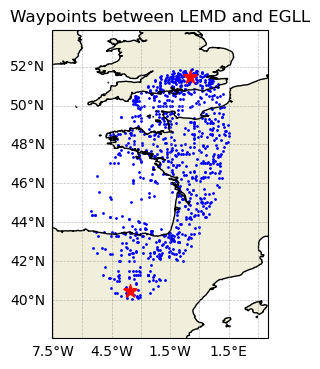

In [11]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature

# Assuming Gm is your NetworkX graph
# Each node in Gm has 'lat' and 'lon' attributes

# Extract latitudes and longitudes
lats = []
lons = []
for node, data in Gm.nodes(data=True):
    lats.append(data['lat'])
    lons.append(data['lon'])

# Calculate the bounds with some padding
min_lon, max_lon = min(lons) - 2, max(lons) + 2
min_lat, max_lat = min(lats) - 2, max(lats) + 2

# Set up the map
fig = plt.figure(figsize=(5, 4))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cartopy.feature.LAND)
ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())

# Plot the waypoints
ax.scatter(lons, lats, color='blue', s=1, transform=ccrs.PlateCarree(), label='Waypoints')
# Add the LEMD and EGLL nodes as stars with text labels
lemd_lon, lemd_lat = Gm.nodes['LEMD']['lon'], Gm.nodes['LEMD']['lat']
egll_lon, egll_lat = Gm.nodes['EGLL']['lon'], Gm.nodes['EGLL']['lat']

# Plot stars for origin and destination
ax.scatter(lemd_lon, lemd_lat, color='red', s=100, marker='*', transform=ccrs.PlateCarree())
ax.scatter(egll_lon, egll_lat, color='red', s=100, marker='*', transform=ccrs.PlateCarree())

# Add gridlines
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

plt.title('Waypoints between LEMD and EGLL')
plt.show()

Then we add the edges to `Gm` from all the segments traversed by `route_df`.

In [12]:
def add_edges_to_Gm(route_df, Gm, haversine_distance):
    """
    For each row in route_df, add edges to Gm for each consecutive pair in real_waypoints.
    
    Parameters
    ----------
    route_df : pandas.DataFrame
        Must contain a column 'real_waypoints' with space‑separated waypoint IDs.
    Gm : networkx.Graph (or DiGraph)
        Graph whose nodes are waypoint IDs, each with 'lat' and 'lon' attributes.
    haversine_distance : callable
        Function lat1, lon1, lat2, lon2 -> distance in nautical miles.
    """
    for idx, row in route_df.iterrows():
        # split into waypoint sequence
        wpts = row['real_waypoints'].split()
        # iterate over each segment
        for u, v in zip(wpts, wpts[1:]):
            if Gm.has_node(u) and Gm.has_node(v):
                lat1, lon1 = Gm.nodes[u]['lat'], Gm.nodes[u]['lon']
                lat2, lon2 = Gm.nodes[v]['lat'], Gm.nodes[v]['lon']
                # compute distance in nautical miles
                dist_nm = haversine_distance(lat1, lon1, lat2, lon2)
                # add edge with dist, tail‑wind, and preference
                Gm.add_edge(u, v,
                           dist=dist_nm,
                           t_wind=0.0,   # default tail‑wind (m/s)
                           pref=0)       # default preference

In [13]:
add_edges_to_Gm(route_df, Gm, haversine_distance)

In [14]:
print(f'The filtered graph has {Gm.number_of_nodes()} nodes and {Gm.number_of_edges()} edges')

The filtered graph has 936 nodes and 2885 edges


In [15]:
# Remove nodes with no connections from Gm
isolated_nodes = list(nx.isolates(Gm))
Gm.remove_nodes_from(isolated_nodes)
print(f"Removed {len(isolated_nodes)} isolated nodes from the graph.")
print(f"The graph now has {Gm.number_of_nodes()} nodes and {Gm.number_of_edges()} edges.")


Removed 246 isolated nodes from the graph.
The graph now has 690 nodes and 2885 edges.


### Airport Connections

In [16]:
from quasar_r12.geometry.airportconn import create_airport_connections
create_airport_connections('LEMD', Gm.nodes['LEMD']['lat'], Gm.nodes['LEMD']['lon'], Gm, distance_threshold_km=90)
create_airport_connections('EGLL', Gm.nodes['EGLL']['lat'], Gm.nodes['EGLL']['lon'], Gm, distance_threshold_km=90)

### Graph Plotting Fn

In [17]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature
import numpy as np

def plot_graph(Gm, show_label=False):
    # Assuming Gm is your NetworkX graph
    # Each node in Gm has 'lat' and 'lon' attributes

    # Extract latitudes and longitudes
    lats = []
    lons = []
    ids = []
    for node, data in Gm.nodes(data=True):
        lats.append(data['lat'])
        lons.append(data['lon'])
        ids.append(node)

    # Calculate the bounds with some padding
    min_lon, max_lon = min(lons) - 2, max(lons) + 2
    min_lat, max_lat = min(lats) - 2, max(lats) + 2

    # Set up the map
    fig = plt.figure(figsize=(10, 14))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines()
    ax.add_feature(cartopy.feature.LAND)
    ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())

    # Plot the waypoints
    ax.scatter(lons, lats, color='blue', s=1, transform=ccrs.PlateCarree(), label='Waypoints')
    # Add text labels for each waypoint
    if show_label:
        for lon, lat, id_text in zip(lons, lats, ids):
            ax.text(lon, lat, id_text, transform=ccrs.PlateCarree(), fontsize=8)
    # Plot the edges
    for u, v in Gm.edges():
        lon1, lat1 = Gm.nodes[u]['lon'], Gm.nodes[u]['lat']
        lon2, lat2 = Gm.nodes[v]['lon'], Gm.nodes[v]['lat']
        ax.plot([lon1, lon2], [lat1, lat2], color='gray', linewidth=0.5, 
                alpha=0.3, transform=ccrs.PlateCarree())

    # Add the LEMD and EGLL nodes as stars with text labels
    lemd_lon, lemd_lat = Gm.nodes['LEMD']['lon'], Gm.nodes['LEMD']['lat']
    egll_lon, egll_lat = Gm.nodes['EGLL']['lon'], Gm.nodes['EGLL']['lat']

    # Plot stars for origin and destination
    ax.scatter(lemd_lon, lemd_lat, color='red', s=100, marker='*', transform=ccrs.PlateCarree())
    ax.scatter(egll_lon, egll_lat, color='red', s=100, marker='*', transform=ccrs.PlateCarree())

    # Add text labels for the airports
    ax.text(lemd_lon+0.2, lemd_lat+0.2, 'LEMD', transform=ccrs.PlateCarree(), fontsize=8)
    ax.text(egll_lon+0.2, egll_lat+0.2, 'EGLL', transform=ccrs.PlateCarree(), fontsize=8)

    # Add gridlines
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False

    plt.title('Plausible Connections between LEMD and EGLL')
    plt.show()

### Gap Filling

In [18]:
from quasar_r12.geometry.filler import fill_graph_gaps
# Enable to fill the gaps between segments, applied for sparse graph data case
# Use smaller tube/min_len for potentially sparser test data
# LEMD_COORD = Gm.nodes['LEMD']['lat'], Gm.nodes['LEMD']['lon']
# EGLL_COORD = Gm.nodes['EGLL']['lat'], Gm.nodes['EGLL']['lon']
# Gm, added_edges = fill_graph_gaps(Gm, LEMD_COORD, EGLL_COORD, max_neighbor_dist_km=120, k_neighbors=5,
#                        max_edges_to_process=10)

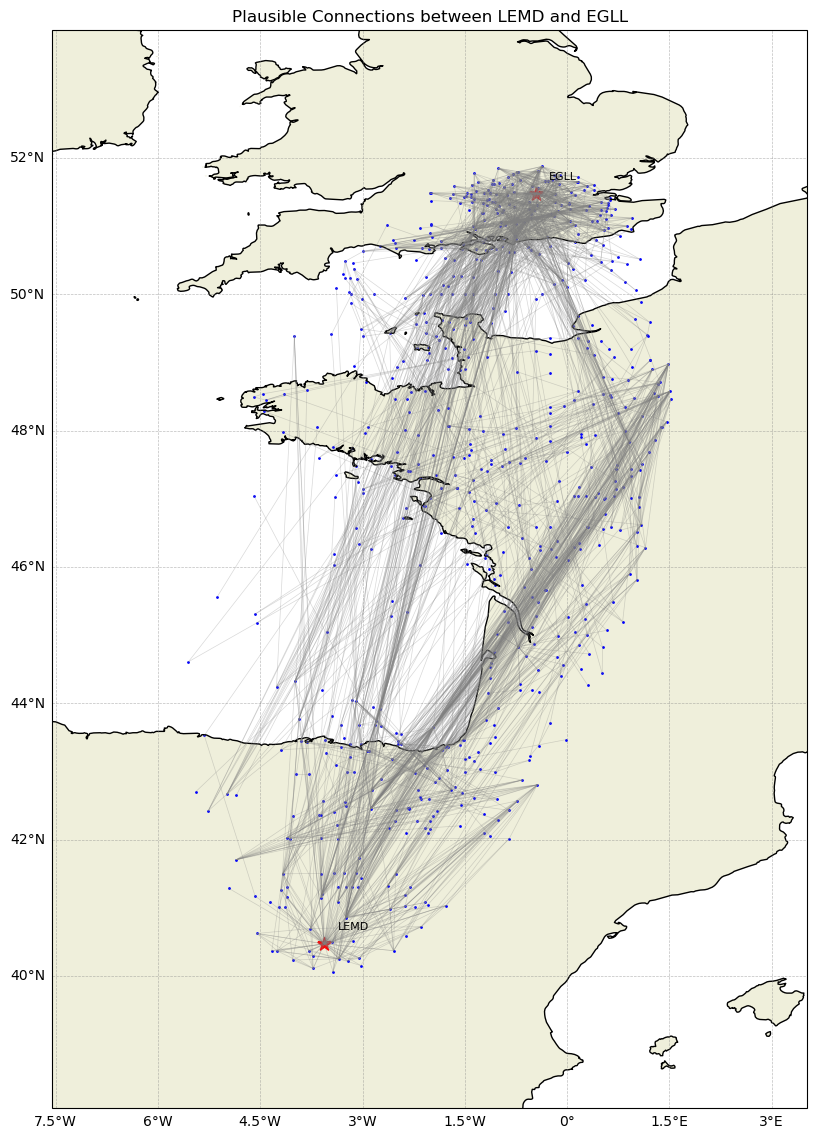

In [19]:
plot_graph(Gm)

### Pruning dead-ends

In [20]:
from quasar_r12.geometry.prunedeadends import prune_dead_ends_and_sharp_turns
try:
    Gmxx_copy = Gm.copy() # Work on a copy
    print(f'Before: {Gmxx_copy.number_of_nodes()} nodes, {Gmxx_copy.number_of_edges()} edges.')
    prune_dead_ends_and_sharp_turns(Gmxx_copy, 'LEMD', 'EGLL', min_turn_angle=45)
    print(f'After: {Gmxx_copy.number_of_nodes()} nodes, {Gmxx_copy.number_of_edges()} edges.')
except (ValueError, KeyError, NameError, Exception) as e:
     print(f"An error occurred: {e}")

Before: 690 nodes, 2945 edges.
After: 221 nodes, 1109 edges.


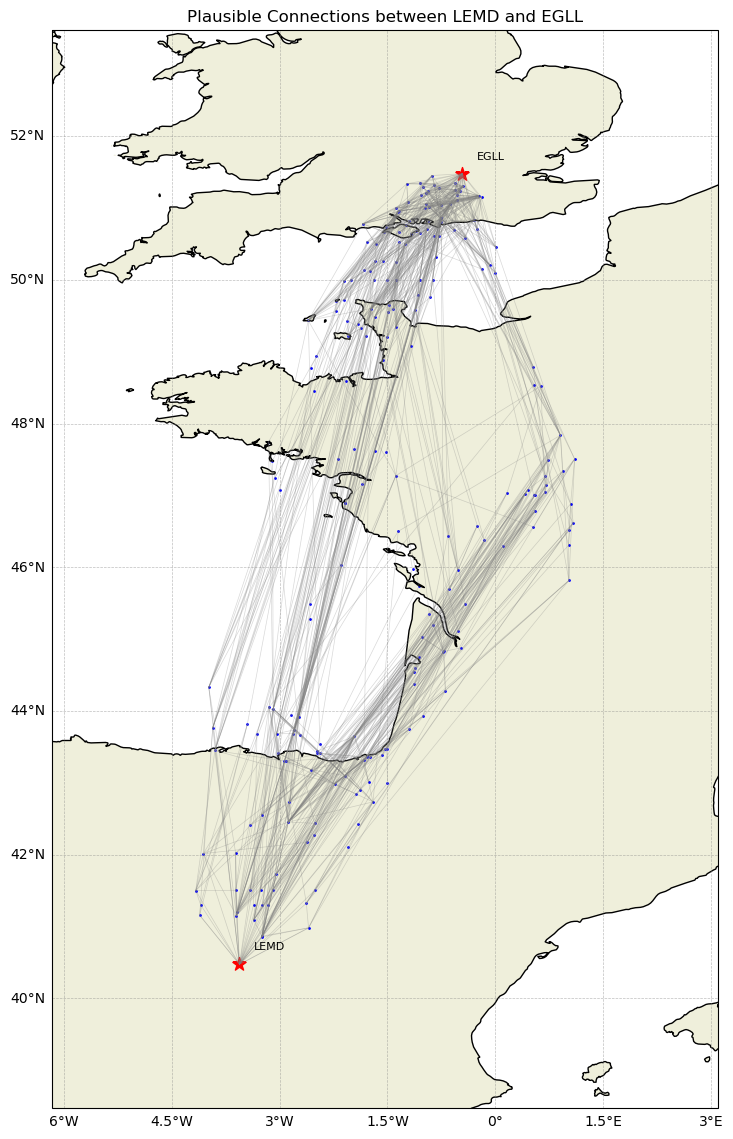

In [21]:
plot_graph(Gmxx_copy)

### Reduce collinear routing options

In [22]:
from quasar_r12.geometry.collinear import refine_graph
for i in range(10):
    refine_graph(Gmxx_copy, 1e-4, 1e-4)
    print(f"Iteration {i+1}: The graph now has {Gm.number_of_nodes()} nodes and {Gm.number_of_edges()} edges.")

Iteration 1: The graph now has 690 nodes and 2945 edges.
Iteration 2: The graph now has 690 nodes and 2945 edges.
Iteration 3: The graph now has 690 nodes and 2945 edges.
Iteration 4: The graph now has 690 nodes and 2945 edges.
Iteration 5: The graph now has 690 nodes and 2945 edges.
Iteration 6: The graph now has 690 nodes and 2945 edges.
Iteration 7: The graph now has 690 nodes and 2945 edges.
Iteration 8: The graph now has 690 nodes and 2945 edges.
Iteration 9: The graph now has 690 nodes and 2945 edges.
Iteration 10: The graph now has 690 nodes and 2945 edges.


Found 20 shortest paths between LEMD and EGLL


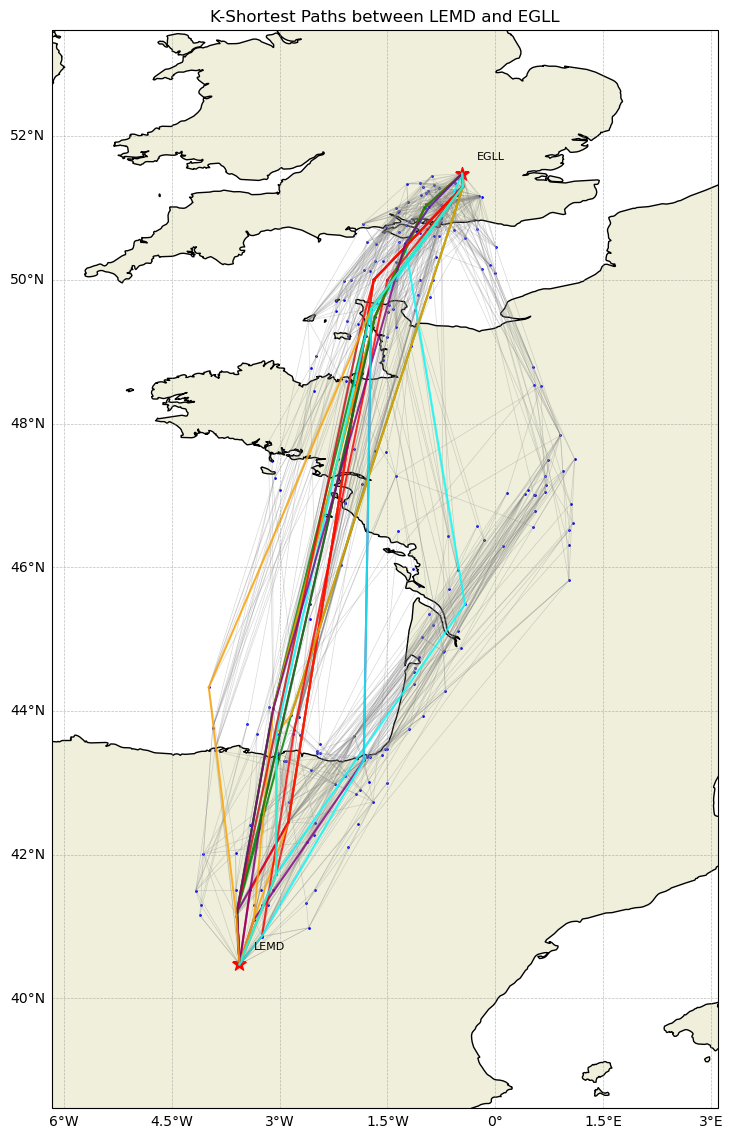


Shortest paths between LEMD and EGLL with distances:
Path 1: LEMD -> LETP -> POPUL -> OCK -> EGLL
Total distance: 1249.30 km
--------------------------------------------------
Path 2: LEMD -> GASMO -> DGO -> BOLRO -> OCK -> EGLL
Total distance: 1260.77 km
--------------------------------------------------
Path 3: LEMD -> LETP -> DGO -> BOLRO -> OCK -> EGLL
Total distance: 1265.27 km
--------------------------------------------------
Path 4: LEMD -> SIE_06 -> DGO -> BOLRO -> OCK -> EGLL
Total distance: 1260.32 km
--------------------------------------------------
Path 5: LEMD -> GASMO -> LFCJ -> VASUX -> NIBDA -> EGLL
Total distance: 1297.74 km
--------------------------------------------------
Path 6: LEMD -> LETP -> NENEM_01 -> UVSUV -> HAZEL -> EGLL
Total distance: 1254.33 km
--------------------------------------------------
Path 7: LEMD -> EDIGO -> DGO -> BOLRO -> OCK -> EGLL
Total distance: 1262.59 km
--------------------------------------------------
Path 8: LEMD -> SIE_06 -> SS

In [23]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature
import numpy as np
import networkx as nx
import math

# Set up the map
fig = plt.figure(figsize=(10, 14))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cartopy.feature.LAND)

# Plot the waypoints
lats = [data['lat'] for _, data in Gmxx_copy.nodes(data=True)]
lons = [data['lon'] for _, data in Gmxx_copy.nodes(data=True)]
ax.scatter(lons, lats, color='blue', s=1, transform=ccrs.PlateCarree())

# Plot the base graph edges
for u, v in Gmxx_copy.edges():
    lon1, lat1 = Gmxx_copy.nodes[u]['lon'], Gmxx_copy.nodes[u]['lat']
    lon2, lat2 = Gmxx_copy.nodes[v]['lon'], Gmxx_copy.nodes[v]['lat']
    ax.plot([lon1, lon2], [lat1, lat2], color='gray', linewidth=0.5, 
            alpha=0.3, transform=ccrs.PlateCarree())

# Find k-shortest paths instead of all paths
try:
    # Find k shortest paths (change k as needed)
    k = 20  # Number of paths to find
    # Use generator to avoid computing all paths at once (faster, less memory)
    path_gen = nx.shortest_simple_paths(Gmxx_copy, 'LEMD', 'EGLL')
    paths = [next(path_gen) for _ in range(k)]
    
    print(f"Found {len(paths)} shortest paths between LEMD and EGLL")
    
    # Plot each path with a different color
    colors = ['green', 'red', 'purple', 'orange', 'cyan']
    for i, path in enumerate(paths):
        color = colors[i % len(colors)]
        for j in range(len(path)-1):
            u, v = path[j], path[j+1]
            lon1, lat1 = Gmxx_copy.nodes[u]['lon'], Gmxx_copy.nodes[u]['lat']
            lon2, lat2 = Gmxx_copy.nodes[v]['lon'], Gmxx_copy.nodes[v]['lat']
            ax.plot([lon1, lon2], [lat1, lat2], color=color, linewidth=1.5, 
                   alpha=0.8, transform=ccrs.PlateCarree())
except Exception as e:
    print(f"Error finding paths: {e}")

# Plot LEMD and EGLL as stars
lemd_lon, lemd_lat = Gm.nodes['LEMD']['lon'], Gm.nodes['LEMD']['lat']
egll_lon, egll_lat = Gm.nodes['EGLL']['lon'], Gm.nodes['EGLL']['lat']
ax.scatter([lemd_lon, egll_lon], [lemd_lat, egll_lat], color='red', 
           s=100, marker='*', transform=ccrs.PlateCarree())
ax.text(lemd_lon+0.2, lemd_lat+0.2, 'LEMD', transform=ccrs.PlateCarree(), fontsize=8)
ax.text(egll_lon+0.2, egll_lat+0.2, 'EGLL', transform=ccrs.PlateCarree(), fontsize=8)

# Set extent based on node coordinates with padding
min_lon, max_lon = min(lons) - 2, max(lons) + 2
min_lat, max_lat = min(lats) - 2, max(lats) + 2
ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())

# Add gridlines
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

plt.title('K-Shortest Paths between LEMD and EGLL')
plt.show()

# Calculate and print the shortest paths with their total distances
print("\nShortest paths between LEMD and EGLL with distances:")
for i, path in enumerate(paths):
    # Calculate the total distance of the path
    total_distance = 0
    for j in range(len(path)-1):
        u, v = path[j], path[j+1]
        # Get the weight of the edge (distance)
        if 'weight' in Gmxx_copy[u][v]:
            edge_distance = Gmxx_copy[u][v]['weight']
        else:
            # If weight is not available, calculate Haversine distance
            lon1, lat1 = Gmxx_copy.nodes[u]['lon'], Gmxx_copy.nodes[u]['lat']
            lon2, lat2 = Gmxx_copy.nodes[v]['lon'], Gmxx_copy.nodes[v]['lat']
            
            # Convert to radians
            lon1, lat1, lon2, lat2 = map(math.radians, [lon1, lat1, lon2, lat2])
            
            # Haversine formula
            dlon = lon2 - lon1
            dlat = lat2 - lat1
            a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
            c = 2 * math.asin(math.sqrt(a))
            r = 6371  # Radius of earth in kilometers
            edge_distance = c * r
            
        total_distance += edge_distance
    
    # Print the path and its total distance
    path_str = " -> ".join(path)
    print(f"Path {i+1}: {path_str}")
    print(f"Total distance: {total_distance:.2f} km")
    print("-" * 50)


Top 20 most connected nodes:
Node: OTSID, Degree: 35
Node: MID, Degree: 34
Node: ABRIX, Degree: 34
Node: DGO, Degree: 33
Node: TELTU, Degree: 32
Node: EGLL, Degree: 32
Node: REVTU, Degree: 31
Node: NOVMA, Degree: 30
Node: LEMD, Degree: 29
Node: EGLF, Degree: 28
Node: GWC, Degree: 27
Node: OCK, Degree: 24
Node: VASUX, Degree: 23
Node: EGTD, Degree: 23
Node: NENEM_01, Degree: 23
Node: BADRU, Degree: 22
Node: LERM, Degree: 22
Node: MAXIT, Degree: 21
Node: DIKRO, Degree: 21
Node: BMC, Degree: 20


/var/folders/r4/52yfj2854bl5v3zcbd28w4_r0000gn/T/ipykernel_15364/2686136406.py:37: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


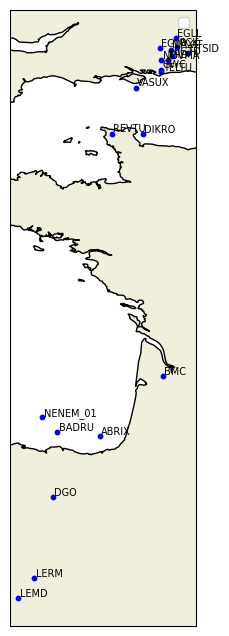

In [24]:
# Find the degree of each node
degrees = dict(Gmxx_copy.degree())

# Sort nodes by degree in descending order
sorted_nodes_by_degree = sorted(degrees.items(), key=lambda item: item[1], reverse=True)

# Get the top 20 nodes
top_20_nodes = sorted_nodes_by_degree[:20]

# Print the top 20 nodes and their degrees
print("Top 20 most connected nodes:")
for node, degree in top_20_nodes:
    print(f"Node: {node}, Degree: {degree}")
    
# Plot the top 20 nodes on the map
try:
    fig = plt.figure(figsize=(5, 8))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines()
    ax.add_feature(cartopy.feature.LAND)
    # Extract coordinates for the top 20 nodes
    top_20_node_ids = [node for node, degree in top_20_nodes]
    top_20_lats = [Gmxx_copy.nodes[node]['lat'] for node in top_20_node_ids]
    top_20_lons = [Gmxx_copy.nodes[node]['lon'] for node in top_20_node_ids]

    # Plot the nodes
    ax.scatter(top_20_lons, top_20_lats, color='blue', s=10, marker='o', 
               transform=ccrs.PlateCarree())

    # Add labels for the nodes
    for node, degree in top_20_nodes:
        lon = Gmxx_copy.nodes[node]['lon']
        lat = Gmxx_copy.nodes[node]['lat']
        ax.text(lon + 0.025, lat + 0.025, node, transform=ccrs.PlateCarree(), fontsize=7)

    # Add a legend to distinguish the top nodes
    ax.legend()

    # Re-show the plot with the new nodes added
    plt.show()

except NameError:
    print("Error: Gmxx, ax, or plt not found. Ensure previous cells were run.")
except Exception as e:
    print(f"Error plotting top 20 nodes: {e}")



In [26]:
nx.write_gml(Gmxx_copy, 'LEMD_EGLL_2023_04_01.gml')

We should also prepare the `RouteContextObject`, containing the tail wind and cross wind information, as well as CAPE, CIN and perhaps *perceived* sector load as well.

# QUASAR 1.2 Training

In [8]:
# Load the context object
from quasar_r12.context import GraphRouteContext 

# Load the context object
context = GraphRouteContext.load(os.path.join(project_root, 'quasar_r12', 'ctx', 'LEMD_EGLL_2023_04_01.context'))